In [1]:
!pip install rouge-score


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install transformers
!pip install torch


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
actual_speeches_dict = {'101112641': ["I thank my colleague. the senior Senator from Alaska. and I thank the Chair. As I think my colleagues have observed. the concern expressed by the senior Senator is not a concern he shares alone. I find It utterly amazing that this agricultural bill there should suddenly be subject to a proposal on fisheries.", "Mr. Leader. for those of us who are on the west coast. Washington. Oregon. Alaska. and Hawaii. as he contemplates the schedule for coming back on Tuesday. would he give some consideration to votes on Tuesday. if he so desires. to coincide with our ability to get back. we can all get back prior to 4:15. but unless we leave on Monday. it is impossible to be here early.", "I commend him for his cooperation and his working with the chairman to the point where we are today. Other Members as well. including Senator MErZENBAUM. Thank you."],
                     '101109290': ["Mr. Chairman. I yield 4 minutes to the gentleman from Louisiana .", "Mr. Chairman. I ask unanimous consent that the amendment in the nature of a substitute made in order as an original text by the rule be printed in the REcoRD and open to amendment at any point.", "Mr. Chairman. I offer amendments and I ask unanimous consent that they be considered en bloc."],
                     '104118220': ["We have touched on the fact that these cuts will be devastating for Medicare recipients.", "If the gentleman will yield. when we are talking about education. we are not just talking about student loans.", "Here you have schools all over America and in the State of Vermont working extremely hard to keep kids off of drugs."]}

generated_speeches_dict = {'101112641': ["I thank my colleague, the hon. member for Saint-Maurice—Champlain, for the opportunity to speak to Bill C-218, An Act to amend the Criminal Code and the Controlled Drugs and Substances Act (sentencing for offences involving trafficking in persons).", "Mr. Leader. for those of us who have been here a long time, this is not the first time that we have had to deal with this issue. We have dealt with it in the past, and we will deal with it in the future.", "I commend him for his cooperation and his willingness to work with us."],
                      '101109290': ["Mr. Chairman. I yield myself such time as I may consume.", "Mr. Chairman. I ask unanimous consent that all Members may have 5 legislative days in which to revise and extend their remarks and to include extraneous material on H.R. 2499, as amended.", 'Mr. Chairman. I offer an amendment to H.R. 1011.\nThe amendment is as follows:\n Page 2, line 1, strike out the word "the" and insert in lieu thereof the word "that".'],
                      '104118220': ["We have touched on this subject before.", "If the gentleman will permit me to say a few words, I shall be glad to do so.", "Here you have schools, colleges, and universities."]}

In [4]:
# Preprocess the texts (optional but recommended)
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = " ".join(nltk.word_tokenize(text))  # Tokenize text into words
    return text

In [5]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def calculate_rouge_bleu_score(id):
    
    # Sample speeches (replace these with your actual speeches)
    actual_speeches = actual_speeches_dict[id]

    generated_speeches = generated_speeches_dict[id]

    actual_speeches = [preprocess_text(text) for text in actual_speeches]
    generated_speeches = [preprocess_text(text) for text in generated_speeches]

    # Calculate BLEU score for each generated speech compared to its corresponding actual speech
    bleu_scores = []
    for actual_speech, generated_speech in zip(actual_speeches, generated_speeches):
        bleu_score = sentence_bleu([actual_speech.split()], generated_speech.split())
        bleu_scores.append(bleu_score)

    # Create a RougeScorer instance
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Calculate ROUGE scores for each generated speech compared to its corresponding actual speech
    rouge_scores = []
    for actual_speech, generated_speech in zip(actual_speeches, generated_speeches):
        scores = scorer.score(generated_speech, actual_speech)
        rouge_scores.append(scores)

    # Print the BLEU scores
    print("BLEU Scores:")
    for i, bleu_score in enumerate(bleu_scores, 1):
        print(f"Speech {i}: {bleu_score}")

    # Print the ROUGE scores
    for i, scores in enumerate(rouge_scores, 1):
        print(f"ROUGE Scores for speech {i}:")
        print(f"ROUGE-1: {scores['rouge1'].fmeasure}")
        print(f"ROUGE-2: {scores['rouge2'].fmeasure}")
        print(f"ROUGE-L: {scores['rougeL'].fmeasure}")

In [6]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from transformers import BartTokenizer, BartModel
import torch

def create_embeddings_and_calculate_cos_sim(id):
    # Sample speeches (replace these with your actual speeches)
    actual_speeches = actual_speeches_dict[id]

    generated_speeches = generated_speeches_dict[id]

    # Download 'punkt' tokenizer data (if not already downloaded)
    nltk.download('punkt')

    # Preprocess the actual and generated speeches
    actual_speeches = [preprocess_text(text) for text in actual_speeches]
    generated_speeches = [preprocess_text(text) for text in generated_speeches]

    # Load BART tokenizer and model
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')

    # Function to create embeddings from text using BART
    def create_bart_embeddings(text):
        input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)
        with torch.no_grad():
            output = model(input_ids)
        embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings

    # Create embeddings for actual speeches and generated speeches
    actual_embeddings = [create_bart_embeddings(text) for text in actual_speeches]
    generated_embeddings = [create_bart_embeddings(text) for text in generated_speeches]

    # Remove None embeddings (if any)
    actual_embeddings = [embed for embed in actual_embeddings if embed is not None]
    generated_embeddings = [embed for embed in generated_embeddings if embed is not None]

    # Calculate cosine similarity between embeddings
    cosine_similarity = np.dot(actual_embeddings, np.array(generated_embeddings).T) / (
        np.linalg.norm(actual_embeddings, axis=1)[:, None] * np.linalg.norm(np.array(generated_embeddings), axis=1)
    )

    # Print cosine similarity for each speech pair
    print("Cosine Similarity:")
    for i in range(len(actual_speeches)):
        for j in range(len(generated_speeches)):
            print(f"Speech Pair ({i+1}, {j+1}): {cosine_similarity[i, j]}")

    # Apply PCA to reduce dimensionality to 3D
    pca = PCA(n_components=3)
    pca_embeddings = pca.fit_transform(np.concatenate((actual_embeddings, generated_embeddings), axis=0))

    # Separate the PCA embeddings back to actual and generated
    actual_pca_embeddings = pca_embeddings[: len(actual_embeddings)]
    generated_pca_embeddings = pca_embeddings[len(actual_embeddings) :]

    # Visualize the embeddings in a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(actual_pca_embeddings[:, 0], actual_pca_embeddings[:, 1], actual_pca_embeddings[:, 2], c='blue', label='Actual Speeches')
    ax.scatter(generated_pca_embeddings[:, 0], generated_pca_embeddings[:, 1], generated_pca_embeddings[:, 2], c='red', label='Generated Speeches')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()


In [7]:
def print_results(id):
    print('Speaker id:' + str(id))
    print('========== Rouge and Bleu Score ==========')
    calculate_rouge_bleu_score(str(id))
    print('========== Cosine Similarities and Embeddings ==========')
    create_embeddings_and_calculate_cos_sim(str(id))


Speaker id:101112641
========== Rouge and Bleu Score ==========
BLEU Scores:
Speech 1: 0.048968081500255126
Speech 2: 0.09234671170792352
Speech 3: 0.15394409880325552
ROUGE Scores for speech 1:
ROUGE-1: 0.23157894736842105
ROUGE-2: 0.08602150537634408
ROUGE-L: 0.16842105263157894
ROUGE Scores for speech 2:
ROUGE-1: 0.29565217391304344
ROUGE-2: 0.10619469026548672
ROUGE-L: 0.22608695652173913
ROUGE Scores for speech 3:
ROUGE-1: 0.5365853658536585
ROUGE-2: 0.41025641025641024
ROUGE-L: 0.48780487804878053
========== Cosine Similarities and Embeddings ==========


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cosine Similarity:
Speech Pair (1, 1): 0.773289144039154
Speech Pair (1, 2): 0.8144320249557495
Speech Pair (1, 3): 0.713881254196167
Speech Pair (2, 1): 0.7190612554550171
Speech Pair (2, 2): 0.8173915147781372
Speech Pair (2, 3): 0.7301946878433228
Speech Pair (3, 1): 0.7410696148872375
Speech Pair (3, 2): 0.8418962359428406
Speech Pair (3, 3): 0.8553577661514282


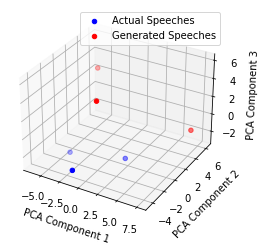

Speaker id:101109290
========== Rouge and Bleu Score ==========
BLEU Scores:
Speech 1: 0.3026643726685863
Speech 2: 0.19286730164506657
Speech 3: 0.09427624888579822
ROUGE Scores for speech 1:
ROUGE-1: 0.36363636363636365
ROUGE-2: 0.3
ROUGE-L: 0.36363636363636365
ROUGE Scores for speech 2:
ROUGE-1: 0.34285714285714286
ROUGE-2: 0.17647058823529413
ROUGE-L: 0.3142857142857143
ROUGE Scores for speech 3:
ROUGE-1: 0.2916666666666667
ROUGE-2: 0.13043478260869568
ROUGE-L: 0.2916666666666667
========== Cosine Similarities and Embeddings ==========


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cosine Similarity:
Speech Pair (1, 1): 0.858843982219696
Speech Pair (1, 2): 0.6746941208839417
Speech Pair (1, 3): 0.7091407775878906
Speech Pair (2, 1): 0.7689682841300964
Speech Pair (2, 2): 0.8744785785675049
Speech Pair (2, 3): 0.8786979913711548
Speech Pair (3, 1): 0.8075712323188782
Speech Pair (3, 2): 0.8506621718406677
Speech Pair (3, 3): 0.810504674911499


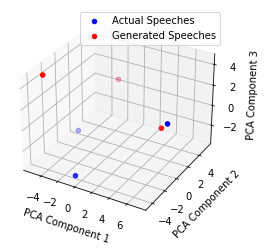

Speaker id:104118220
========== Rouge and Bleu Score ==========
BLEU Scores:
Speech 1: 0.13448025110102005
Speech 2: 0.11467654757780467
Speech 3: 0.07922918063551808
ROUGE Scores for speech 1:
ROUGE-1: 0.36363636363636365
ROUGE-2: 0.3
ROUGE-L: 0.36363636363636365
ROUGE Scores for speech 2:
ROUGE-1: 0.21621621621621623
ROUGE-2: 0.17142857142857143
ROUGE-L: 0.21621621621621623
ROUGE Scores for speech 3:
ROUGE-1: 0.3448275862068965
ROUGE-2: 0.22222222222222224
ROUGE-L: 0.3448275862068965
========== Cosine Similarities and Embeddings ==========


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cosine Similarity:
Speech Pair (1, 1): 0.7679676413536072
Speech Pair (1, 2): 0.7184901833534241
Speech Pair (1, 3): 0.6206689476966858
Speech Pair (2, 1): 0.7262407541275024
Speech Pair (2, 2): 0.7543808817863464
Speech Pair (2, 3): 0.694109320640564
Speech Pair (3, 1): 0.6464053392410278
Speech Pair (3, 2): 0.7098845839500427
Speech Pair (3, 3): 0.638637900352478


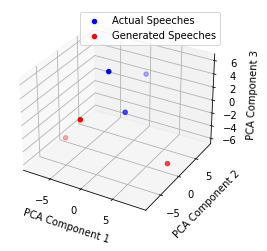

In [8]:
print_results(101112641)
print_results(101109290)
print_results(104118220)